# Set up 


In [42]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
from scipy.optimize import LinearConstraint
import scipy.optimize as optimize
import threading
# from rpy2.robjects.packages import importr, data
# from rpy2.robjects.lib.dplyr import DataFrame
from datetime import datetime


In [43]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()

# Parameter set

In [44]:
global boost, alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; t0 = {}


boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

# s["all"]=0.01
s["ss2"]=0.01
s["ss4"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c = 0.3938

Old_crit = 1.9197
New_crit = -2.33
t0["all"] = 699.98
t0["ann"] = 699.98

kao = 37

#---CM
F["CM_oldiold_oldinew"] = 0.2

L["CM_oldiold_newinew"] = 0.2
L["CM_oldinew_newiold"] = 0.2

#---AN
F["AN_oldiold_oldinew"] = 0.2

# Assign LTM global

In [45]:
def assign_LTM_global(item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    
    if item_condi=="CM":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["CM_oldiold_oldinew"]
        else: Fnow = 0
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":
            
            Lnow = L["CM_oldiold_newinew"]
        elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":
            
            Lnow = L["CM_oldinew_newiold"]
        else: Lnow=0
            
    if item_condi == "AN":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["AN_oldiold_oldinew"]
        else: Fnow=0
        
        Lnow = 0
    
    return(Fnow + Lnow)

assign_LTM_global("AN","old","old")
        

0.2

# Calc A (activation)

In [46]:
# seperate albes
def calcA(df, name):

    
    dnow = df[df['FileCondi']==name]
    a = np.zeros((dnow.shape[0], 8))  #activation
    
    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):
        
        indexj = j-1
        a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==2),indexj] = m[indexj] * s["ss2"]
        a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==4),indexj] = m[indexj] * s["ss4"]
        a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
        a[dnow["Lag"]==j,indexj] = m[indexj]
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
#                   "\n snow", snow,\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df[df["Error"]==0], "CMat"))

name="MIX"
A0=calcA(df,name)
A0
# df_sub= df[df['FileCondi']==name]
# show =[df_sub["FileCondi"].iloc[i]+\
#         "-- "+A0[i].round(5).astype(str)+\
#       "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
#       "--"+df_sub["Probtype"].iloc[i]+\
#       "--"+df_sub["Oldnew"].iloc[i] for i in range(A0.size)]
# print(np.sort(show))

array([0.01815275, 0.01815275, 0.01815275, 0.01815275, 0.0265232 ,
       0.0265232 , 0.0265232 , 0.0265232 , 0.03853018, 0.03853018,
       0.03853018, 0.03853018, 1.19625275, 1.19625275, 0.63717528,
       0.63717528, 1.19625275, 1.19625275, 0.63717528, 0.63717528,
       1.2046232 , 1.2046232 , 0.64554573, 0.64554573, 0.47952792,
       0.47952792, 0.40219313, 0.40219313, 1.2046232 , 1.2046232 ,
       0.64554573, 0.64554573, 0.47952792, 0.47952792, 0.40219313,
       0.40219313, 1.21663018, 0.65755271, 0.4915349 , 0.4915349 ,
       0.41420011, 0.41420011, 0.37013656, 0.37013656, 0.34193666,
       0.34193666, 0.32246373, 0.32246373, 0.30827473, 0.30827473,
       1.21663018, 1.21663018, 0.65755271, 0.65755271, 0.4915349 ,
       0.4915349 , 0.41420011, 0.41420011, 0.37013656, 0.37013656,
       0.34193666, 0.34193666, 0.32246373, 0.32246373, 0.30827473,
       0.30827473])

# Calc p (drift rate)

In [47]:

def calcp(df, name):
    
    A = calcA(df, name)
    dnow = df[df['FileCondi']==name]
    p = np.repeat(3.0, A.shape[0])
    
    probs = dnow["Probtype"].astype("category").cat.categories.to_numpy() #get categories name
    

    for iprob in probs:
        
        for ion in ["old","new"]:
            
            tf_ion = dnow['Oldnew'] == ion
            tf_iprob = dnow['Probtype'] == iprob
            tf_all = np.logical_and(tf_ion, tf_iprob)
            
            IR_old_current = assign_LTM_global(iprob,"old",ion)
            IR_new_current = assign_LTM_global(iprob,"new",ion)
        
            p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + IR_new_current)
        
#             print("**","MIX",iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])
    return(np.array(p))

p0=calcp(df,"MIX")

# ok1=calcp(df, "MIX")
# on = df[df['FileCondi']=="MIX"]["Oldnew"]
# onn = df[df['FileCondi']=="MIX"]["Probtype"]
# ss = df[df['FileCondi']=="MIX"]["Setsize"]
# lagg = df[df['FileCondi']=="MIX"]["Lag"]
# # print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) for i in range(ok1.shape[0])]))
# print(np.array([str(ok1[i].round(8))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i])+"-ss:"+str(ss.iloc[i])\
#                 + "-lag:" + str(lagg.iloc[i]) for i in range(ok1.shape[0])]))


name="MIX"
df_sub = df[df['FileCondi']==name]
p0=calcp(df,name)
show =[df_sub["FileCondi"].iloc[i]+\
       "--"+df_sub["Probtype"].iloc[i]+\
       "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
       "--"+df_sub["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
# print(np.sort(show))

# RW 

In [48]:

def calc_theoretical_RW(df, name, which):
    
    A = calcA(df,name)
    p = calcp(df,name)
    q = 1-p
    
    dnow = df[df['FileCondi']==name]
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    
    AA = Old_crit
    BB = -New_crit # bb is a postive number
    
    exp_nstep = np.zeros(p.shape[0])
    if which=="crt":

        theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
        theta2 = ((p/q)**BB+1)/((p/q)**BB-1)


        tf = np.logical_and(p!=q , dnow["Oldnew"]=='old')
        exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

        tf = np.logical_and(p==q , dnow["Oldnew"]=='old')
        exp_nstep[tf] = (AA/3)*(2*BB+AA)

        theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
        theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)

        tf = np.logical_and(p!=q , dnow["Oldnew"]=='new')
        exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*AA)
        tf = np.logical_and(p==q , dnow["Oldnew"]=='new')
        exp_nstep[tf] = (BB/3)*(2*AA+BB)
        
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]


    #------------------- correct response
    elif which == "err":

        p_resp_old[p!=q] = ((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]
        p_resp_old[p==q] = BB/(AA+BB)

        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          





name="MIX"
df_sub = df[df['FileCondi']==name]
rw=calc_theoretical_RW(df_crt,name,"crt")
# show =[df_sub["FileCondi"].iloc[i]+\
#        "--"+df_sub["Probtype"].iloc[i]+\
#        "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
#        "--"+df_sub["Oldnew"].iloc[i]+\
#        "-- "+rw[i].round(5).astype(str) for i in range(A0.size)]
# # print(np.sort(show))

# Calculate WSSE

In [49]:
fitsel = pd.read_csv("12_02_12_33_puresingle_test_MIX2_vary_ss.csv")
fitsel

,Unnamed: 0,alpha,beta,s_ss2,s_ss4,s_ss8,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool,wssd,w
0,0,0.243584349170678,2.29576438126046,0.01,0.013194592807346,0.021462827426077,0.200461958126083,3.82795730370735,-3.6028704054025,638.730233835774,742.716726397961,29.8942157715742,0.056204960874706,0.043945120786779,0.033945120789737,1.29965679563005E-11,3.201999,new_rt:50
1,1,0.244027927068505,2.2938744068807,0.010000000000111,0.013201351379523,0.021466016963274,0.200821380871323,3.82825713947544,-3.60258779946881,638.571285947617,742.676947828319,29.9081794539222,0.056321985043696,0.044019365958745,0.034019365958948,1.91712562233586E-13,3.222514,old_rt:10
2,2,0.257812165732617,2.24736095108911,0.01,0.013305596734106,0.021634634363348,0.211571360601621,3.92320731328931,-3.63307345009048,635.582935810951,745.315560393506,29.2589959257338,0.060926024106956,0.04836335474817,0.038363354748172,0,3.759242,new_err:5
3,3,0.151105232569456,2.65791490956432,0.010000000031572,0.0132211556471,0.022399906575411,0.167987545164338,3.80302831767269,-4.09485800231419,689.342266015696,701.652332448786,22.2998105676819,0.057252919795242,0.013601068076938,0.003601068106534,0.036551289402449,0.836318,old_err:1
4,4,0.241966169988135,2.30191523706527,0.010000000000381,0.013179119717044,0.02143127519917,0.199082109593695,3.81700827093649,-3.59791017720972,638.976779642932,742.314322964718,29.9951899380152,0.055647341104556,0.043399227006582,0.033399227002703,0,3.149768,--------------
5,5,0.2451262106944,2.28976432609157,0.01,0.013216438232755,0.021491653576453,0.201817415871007,3.83288710223022,-3.60702066014934,638.449938511143,742.844620096586,29.8504229523005,0.056634374199839,0.044348636700855,0.03434863670085,1.63891775567511E-15,3.256967,--------------
6,6,0.150143073831689,2.66512104276131,0.01,0.013204652690356,0.022360100444448,0.166727773528468,3.81168417046603,-4.08876611291778,689.414121002821,701.768171140926,22.275744103188,0.056964238182511,0.01359208066483,0.003592080664735,0.036357785643444,0.840368,--------------
7,0,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.000000,--------------


In [50]:
[alpha["all"],
beta["all"],
s["ss2"],s["ss4"],s["ss8"],
c,
Old_crit,
New_crit,
t0["all"],
t0["ann"],
kao,
F["CM_oldiold_oldinew"],
L["CM_oldiold_newinew"],
L["CM_oldinew_newiold"],
F["AN_oldiold_oldinew"]]=fitsel.iloc[4,1:fitsel.shape[1]-2].astype(float).to_list()

for i in [400,450,500,550,600,650]:
#     t0["all"]=i
    name="MIX2"
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    df_sub_err=df_sub_err[df_sub_err["FileCondi"]==name]
    df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]==name]
    print("\n-----",i,calc_theoretical_RW(df_sub_crt,"MIX2","crt"),df_sub_crt["RT"])
#     print("\n-----",calcA(df_sub_crt,name))


----- 400 [870.19223099 890.89858791 888.59984014 914.59538661 961.01156487
 982.80175074 796.58989351 903.45306302 800.74709369 895.76442874
 796.21508163 898.58431139 963.45500298 991.62027121 800.36210807
 891.93344684 941.00978192 961.91748483 795.03269007 884.97256904
 938.98511627 963.10900325 974.61318122 980.73911315 984.31807087
 986.56519834 799.14474418 881.03398334 922.87806271 940.75450608
 949.24824902 953.78767056 956.45015203 958.12702553] 3       896.760000
7       866.102908
12      887.398649
16      909.243956
21      937.880392
25     1012.118812
30      798.801653
34      781.254310
38      802.816667
42      930.840376
48      767.435185
52      883.847458
56      896.247191
60     1006.974138
64      783.481481
68      901.890909
72      970.726415
76      984.019802
84      914.150000
88      907.671875
92     1001.629032
96     1006.745455
100     983.275000
104     981.147541
108    1006.672131
112     936.770492
116     775.457627
120     842.078125
124    

In [52]:
w={}
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1
# w["new_rt"] = 4 *1.4  #2 is how many rt more than err
# w["old_rt"] = 1 
# w["new_err"] = 4 *1.1
# w["old_err"] = 4  *8

# w["new_rt"] = 1 *25 #2 is how many rt more than err
# w["old_rt"] = 1 
# w["new_err"] = 1  *20
# w["old_err"] = 1
# w["new_rt"] = 1 *10 *5
# w["old_rt"] = 1 *10
# w["new_err"] = 1 *5
# w["old_err"] = 1 

def calc_wssd(df_err,df_crt, name):

    
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    df_sub_err=df_sub_err[df_sub_err["FileCondi"]==name]
    df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]==name]
    
    df_sub_err = df_sub_err.reset_index()
    df_sub_crt = df_sub_crt.reset_index()

    pred_correct = calc_theoretical_RW(df_err, name, "err")
    pred_crt= calc_theoretical_RW(df_crt, name,"crt")


    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

# time1=time.time()
calc_wssd(df_err,df_crt, "MIX2")

# print(time.time()-time1)
# df_sub_agg, WSSD = calc_wssd(df, "MIX")



0.23980488000840738

# Parameter search

## Asign parm_dic

In [53]:
param_dic=np.array((
    
    alpha["all"],
    beta["all"],
    s["ss2"],s["ss4"],s["ss8"],
    
    c,
    
    Old_crit,
    New_crit,
    
    t0,
    kao,

    #---CM
    F["CM_oldiold_oldinew"],

    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],

    #---AN
    F["AN_oldiold_oldinew"]
))
param_dic

array([0.241966169988135, 2.30191523706527, 0.010000000000381,
       0.013179119717044, 0.02143127519917, 0.199082109593695,
       3.81700827093649, -3.59791017720972,
       {'all': 638.976779642932, 'ann': 742.314322964718},
       29.9951899380152, 0.055647341104556, 0.043399227006582,
       0.033399227002703, 0.0], dtype=object)

## optim_wsse

In [54]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L,t

    alpha={}; beta ={}; s = {}; F = {}; L={};t={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    [
        alpha["all"],
        beta["all"],
        s["ss2"],s["ss4"],s["ss8"],
        c,

        Old_crit,
        New_crit,

        t0["all"],
        t0["ann"],
        
        kao,

        #---CM
        F["CM_oldiold_oldinew"],

        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],

        #---AN
        F["AN_oldiold_oldinew"]] = params_dic
    


    return calc_wssd(df_err,df_crt, "MIX2")


## random start

In [55]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L,t
  
    alpha={}; beta ={}; s = {}; F = {}; L = {};t={}

    alpha["all"] = np.random.uniform(0.1,1)
    beta["all"] =np.random.uniform(1,2)
    s["ss2"]= np.random.uniform(0.01,0.999)
    s["ss4"]= np.random.uniform(0.01,0.999)
    s["ss8"]= np.random.uniform(0.01,0.999)
    c = np.random.uniform(0.05,0.99)

    Old_crit = np.random.uniform(1,5)
    New_crit = np.random.uniform(-5,-1)
    t0["all"] = 699
    t0["ann"]=699
    kao = 37

    #---CM
    F["CM_oldiold_oldinew"] = np.random.uniform(0.01,1)

    L["CM_oldiold_newinew"] = np.random.uniform(0.01,1)
    L["CM_oldinew_newiold"] = np.random.uniform(0.001,1)

    #---AN
    F["AN_oldiold_oldinew"] = np.random.uniform(0.001,1)
    
    param_dic=[
        alpha["all"],
        beta["all"],
        s["ss2"],s["ss4"],s["ss8"],
        c,
        Old_crit,
        New_crit,
        t0["all"],
        t0["ann"],
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]]
    return(param_dic)

bdd = (

(0.01, 1.0), #alphaall
(0.01, 3.0), #beta_all
(0.01, 1.0), #s all
(0.01, 1.0), #s all
(0.01, 1.0), #s all

(0.01, 2), #c

(1, 8.0), #old_cr
(-8.0, -1), #new_cr
(100, 800), #t0_all
(100, 800), #t0_ann
(5, 100), #kao

(0,2),#F["CM_oldiold_oldinew"],

(0,2),#L["CM_oldiold_newinew"],
(0,2),#L["CM_oldinew_newiold"],

#---AN
(0,2)#F["AN_oldiold_oldinew"]
  )
def apply_sum_constraint(inp):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L={}
    
    [
        alpha["all"],
        beta["all"],
        s["ss2"],s["ss4"],s["ss8"],
        c,
        Old_crit,
        New_crit,
        t0["all"],
        t0["ann"],
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]] = inp
    
    suffice = 1 
    suffice = 1- ((np.logical_and(L["CM_oldiold_newinew"]>L["CM_oldinew_newiold"],\
                                  F["CM_oldiold_oldinew"]>F["AN_oldiold_oldinew"]))).astype('float')
    
    return suffice

def Jcstrain():
    linear_constraint = LinearConstraint(\
       [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],
        [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
        [0.01, 0.01],[np.inf,np.inf])

    return(linear_constraint)

## Actual search

In [56]:
# def actual_search():
# # cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
#     my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })

#     time1 = time.time()
    
#     global fitted_params2
    
#     numit = 6
#     fitted_params2 = np.zeros((numit,12))
#     for i in range(1,6):
#         param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={"maxiter" : 100,'eps': 1},constraints=my_constraints)
#         print(i)
#         if result.success:
#             fitted_params2[i,:] = result.x
#         else: 
#             print(result.message)

# #     fitted_params2[1,6]=9
#     print(fitted_params2)
#     time2 = time.time()
#     print(time2-time1)
    
def actual_search():# 

    time1 = time.time()
    numit=15
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,np.array(bdd).shape[0]))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)


## Write in file

In [59]:
# actual_search()

def write_file(which_work):
    
    Parnames = ["alpha","beta","s_ss2","s_ss4","s_ss8",
                "c","old_crt","new_crt","t0","t0ann","kappa","F_cmoonn","L_cmoonn","Lcmonno","an_oool"]

#     fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    
    
    #======= write wssd
    wssd_all = np.zeros(fitsel.shape[0])
    for i in range(fitsel.shape[0]-1):
        [alpha["all"], beta["all"], s["ss2"],s["ss4"],s["ss8"], c, Old_crit, New_crit, t0["all"],
          t0["ann"], kao, F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"],
          L["CM_oldinew_newiold"], F["AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
        wssd_all[i]=calc_wssd(df_err,df_crt,"MIX2")
    fitsel["wssd"]=wssd_all
    filen = current_time + "_" + which_work + ".csv"
    #=======
    #=====
    w_curr=np.repeat("--------------",fitsel.shape[0])
    w_keys = [i for i in w.keys()]
    w_values=[i for i in w.values()]
    for i in range(len(w_keys)):
        w_curr[i]= w_keys[i]+":"+str(w_values[i])

    fitsel["w"]=w_curr
    #===============
    
    filen = current_time + "_" + which_work + ".csv"
    fitsel.to_csv(filen)

    return(fitsel)
    

current = "puresingle_test_MIX2_vary_ss"

fitsel=write_file(current)
fitsel

,alpha,beta,s_ss2,s_ss4,s_ss8,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool,wssd,w
0,0.247829,2.43875,0.01,0.0187669,0.0246617,0.295118,5.16057,-4.49742,676.555,710.188,15.0797,0.135617,0.0638775,0.0538775,0.101532,16.785919,new_rt:8
1,0.246453,2.44475,0.01,0.0186948,0.0246066,0.292536,5.12574,-4.48707,676.947,709.987,15.1962,0.133621,0.0635025,0.0535025,0.0999409,16.850228,old_rt:2
2,0.24549,2.45204,0.01,0.0186867,0.0245598,0.290324,5.11829,-4.47245,676.781,710.114,15.273,0.1324,0.0629195,0.0529195,0.0987922,16.901916,new_err:4
3,0.240878,2.47203,0.01,0.0185525,0.0244034,0.282628,5.0781,-4.43465,677.224,709.89,15.4948,0.128068,0.061218,0.051218,0.0952127,17.085694,old_err:1
4,0.244755,2.45302,0.01,0.018679,0.0245572,0.2893,5.11672,-4.46705,676.915,710.075,15.2855,0.131892,0.0628044,0.0528044,0.0983869,16.923844,--------------
5,0.246588,2.44241,0.01,0.0188109,0.0247032,0.293338,5.1404,-4.49927,677.332,710.61,15.0911,0.133936,0.0640013,0.0540013,0.100101,16.828400,--------------
0,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.000000,--------------


# Final Random Walk

## finalRW()

In [40]:
s_AN=0.01
s_others = 0.07
def finalRW(df_what_org, name, kind):
    
    df_what = df_what_org.copy()
    df_what = df_what[df_what["FileCondi"]==name]
    df_what = df_what.reset_index()
    
    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,name, kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,name, kind)
    else: print("error input of name kind")
    
    return(df_what)

finalRW(df_err, "MIX", "err")

,level_0,index,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,Pred_error
0,2,2,new,2,AN,0,MIX,0.026667,0.261799
1,6,6,new,2,CM,0,MIX,0.039583,0.367577
2,11,11,new,4,AN,0,MIX,0.037344,0.276955
3,15,15,new,4,CM,0,MIX,0.116034,0.377194
4,20,20,new,8,AN,0,MIX,0.052632,0.298664
5,24,24,new,8,CM,0,MIX,0.190776,0.390849
6,29,29,old,2,AN,1,MIX,0.039841,0.047996
7,33,33,old,2,AN,2,MIX,0.048193,0.137539
8,37,37,old,2,CM,1,MIX,0.056225,0.086181
9,41,41,old,2,CM,2,MIX,0.041667,0.197683


## Assign param

In [139]:
fitsel

,alpha,beta,s,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool
0,0.374106,1.00058,0.0300038,0.502996,3.21086,-4.16848,506.94,509.264,33.7678,0.124164,0.0546136,0.0446136,0.0492099
1,0.380151,0.760197,0.0383725,0.882313,5.26434,-6.79298,517.897,529.977,12.4709,0.36777,0.196073,0.186073,0.280153
0,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0


In [15]:
# fitsel = pd.read_csv("11_25_02_36_single_test.csv").iloc[:,1:]
[alpha["all"],
beta["all"],
s["all"],
c,
Old_crit,
New_crit,
t0["all"],
t0["ann"],
kao,
F["CM_oldiold_oldinew"],
L["CM_oldiold_newinew"],
L["CM_oldinew_newiold"],
F["AN_oldiold_oldinew"]]=\
fitsel.iloc[1,:].astype(float).to_list()

NameError: name 'fitsel' is not defined

# Plot

## all_plot()

In [ ]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1


## Error plot

/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: cannot handle a non-unique multi-index!

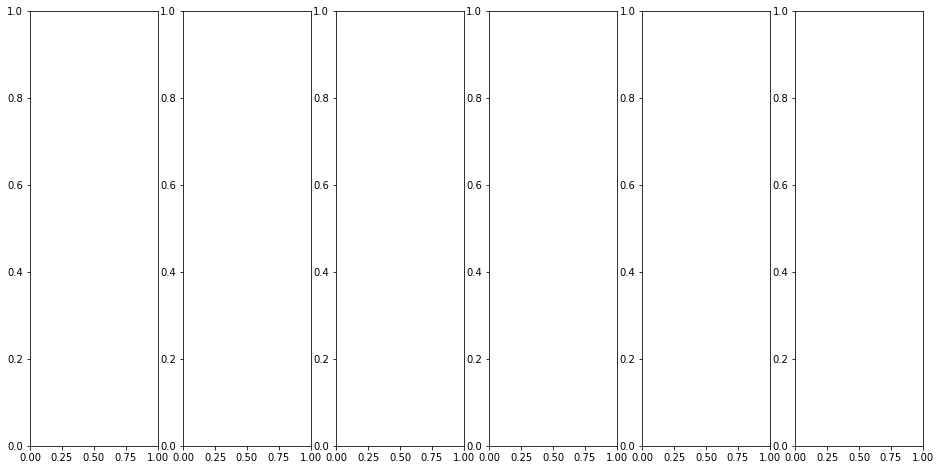

In [16]:
assign_value=0
if assign_value == 1:
    [alpha["all"],
    beta["all"],
    s["all"],
    c,
    Old_crit,
    New_crit,
    t0,
    kao,
    F["CM_oldiold_oldinew"],
    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],
    F["AN_oldiold_oldinew"]]=[
    0.3,
    0.2,
    0.250000028640636132,
    0.690640191843181,
    3.999999835304936,
    -2.194458887105686,
    699.0,
    37.0,
    0.9785718066582388,
    0.9899999996042117,
    0.01,
    0.01]
# print(L["CM_oldinew_newiold"])
df_all_crt, df_all_err = finalRW(df_org)



df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


# df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "pred_error",(0,1))


In [ ]:
all_plot(df_all_aggnew, "Error",(0,0.3))

## correct RT plot

In [ ]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_crt.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew

all_plot(df_all_aggnew, "RT",(600,1100))
all_plot(df_all_aggnew, "pred_rt",(600,1100))

In [17]:
df_err_sub=df_err[df_err["FileCondi"]=="MIX"]

df_err_pred = finalRW(df_err_sub,"err")

df_err_pred

TypeError: finalRW() takes 1 positional argument but 2 were given